In [1]:
import os
import pathlib
import subprocess
import matplotlib.pyplot as plt

import flytekit
import tensorflow as tf
from flytekit import task, workflow, Resources
from flytekit.types.directory import FlyteDirectory
from flytekit.core.base_task import IgnoreOutputs
from flytekitplugins.kfmpi import MPIJob

In [5]:
# Load the training data from the mnist dataset
_, (test_images, test_labels) = \
        tf.keras.datasets.mnist.load_data(path='mnist-%d.npz' % 1000)

# Preprocess the data (these are NumPy arrays)
test_images = tf.cast(test_images[..., tf.newaxis] / 255.0, tf.float32)
test_labels = tf.cast(test_labels, tf.int64)

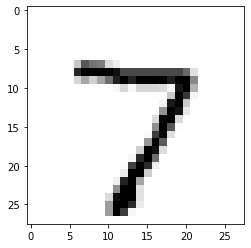

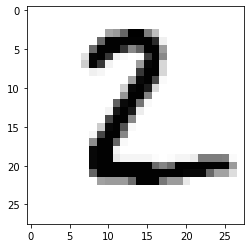

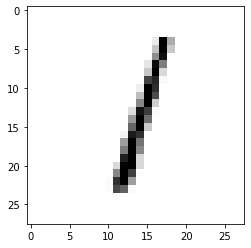

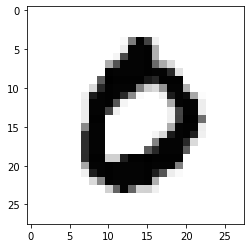

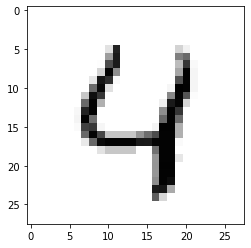

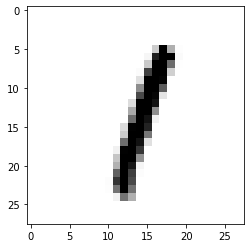

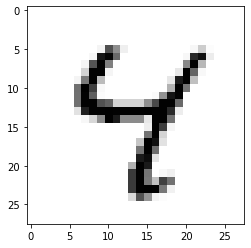

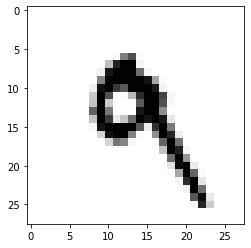

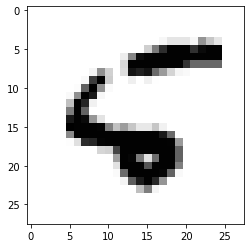

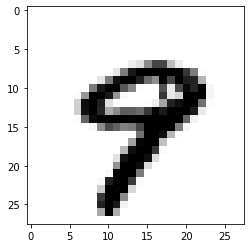

In [8]:
# Let's take a preview of our test data:
for i in range(10):
    img = test_images[i]
    plt.imshow(img, cmap="Greys")
    plt.show()

In [9]:
from flytekit.remote import FlyteRemote

# Initialize the remote client to talk to the Flyte deployment using the project: "flytesnacks"
# and domain "development" and specified config file.
remote = FlyteRemote.from_config("flytesnacks", "development", "/Users/katrina/.flyte/config")

# Fetch the launch_plan, used to trigger a new workflow execution
flyte_launch_plan = remote.fetch_launch_plan(name="kfmpi.mpi_mnist.horovod_training_wf",
                                             version="3bbc6086d4c5857566719ad4fc729370940808b4")

# Create a new Flyte execution
execution = remote.execute(flyte_launch_plan,
                           {"batch_size": 128, "buffer_size": 1000, "dataset_size": 1000})
print(f"Created execution: {execution.id}")



{"asctime": "2021-09-26 15:13:18,811", "name": "flytekit.remote", "levelname": "WARNING", "message": "This feature is still in beta. Its interface and UX is subject to change."}


No images specified, will use the default image
Created execution: ex:flytesnacks:development:f1929fea63bf8459cb74


In [10]:
# In a separate script, we can also fetch our execution like so:
# execution = remote.fetch_workflow_execution("flytesnacks", "development", "ff88cc76349a24f7f8e4")

execution = remote.sync(execution)

# Fetch the execution outputs, in this case the trained mnist model checkpoint directory.
output_dir = execution.outputs["o0"]
output_dir.download()
    

'/var/folders/df/rkj_t8p97852_3rgl3bdlg300000gn/T/flyterm9xqa5c/control_plane_metadata/local_flytekit/4605f4020eda3bda0112ff90891bb2c4'

In [11]:
from tensorflow import keras
# checkpoint_path = os.path.join(output_dir)
model = keras.models.load_model(output_dir)
model.compile('adam', metrics='accuracy')
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("trained model, accuracy: {:5.2f}%".format(100 * acc))

313/313 - 1s - loss: 0.0000e+00 - accuracy: 0.9868
trained model, accuracy: 98.68%


In [ ]:
model.